In [66]:
# Importação de bibliotecas externas necessárias
from deap import base, creator, tools, benchmarks
import deap.cma as cma

import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import math
import time
import pandas as pd

# Importação de módulos personalizados
from Modules.Helper import Helper
from Modules.Solvers import Solvers
from Modules.Plotters import Plotters
from Modules.Equation import Equation

In [67]:
# Carrega os dados do sistema GRN5 e define as condições iniciais
labels = ['A', 'B', 'C', 'D', 'E']
df, max_data = Helper.load_data(filename='Data/CicloCelular_DATA.txt', labels=labels)
initial_conditions = np.array([df[label].iloc[0] for label in labels])
t_span = (df['t'].iloc[0], df['t'].iloc[-1])  # Intervalo de tempo para simulações
t_eval = np.array(df['t'])  # Ponto de avaliação dos dados temporais
original = np.array(df[labels]).T  # Dados originais para cálculo de erro

In [68]:
# Limites nos valores dos coeficientes tau, k e n 
bounds = {
    'tau': (0.1, 5.0),
    'k': (0.1, 2.0),
    'n': (0.1, 30.0)
}

IND_SIZE = 23  # Tamanho do indivíduo (número total de coeficientes)

In [69]:
# Representa um coeficiente com valor e limites
class Coefficient:
    def __init__(self, bounds_val):
        self.val = random.uniform(*bounds_val)  # Inicializa com valor aleatório dentro dos limites
        self.bounds_val = bounds_val
    
    def __repr__(self):
        return f"val={self.val}"

# Representa um coeficiente usado no CMA-ES com limites.
class CMACoefficient:
    def __init__(self, val, bounds_val):
        self.bounds_val = bounds_val
        self.val = self.limit_val(val)  # Ajusta o valor aos limites
    
    # Garante que o valor esteja dentro dos limites
    def limit_val(self, val):
        return max(self.bounds_val[0], min(val, self.bounds_val[1]))
    
    def __repr__(self):
        return f"val={self.val}"

In [70]:
# Representa um indivíduo contendo coeficientes e funções para manipulação
class Individual:
    def __init__(self):
        # Estrutura do indivíduo contendo os coeficientes para cada variável
        self.coeffs = {
            'A': {
                'E': {'n': None, 'k': None, '-': True},
                'tau': None
            },
            'B': {
                'A': {'n': None, 'k': None, '-': False},
                'C': {'n': None, 'k': None, '-': False},
                'tau': None
            },
            'C': {
                'A': {'n': None, 'k': None, '-': False},
                'C': {'n': None, 'k': None, '-': False},
                'E': {'n': None, 'k': None, '-': False},
                'tau': None,
            },
            'D': {
                'E': {'n': None, 'k': None, '-': True},
                'tau': None,
            },
            'E': {
                'A': {'n': None, 'k': None, '-': False},
                'E': {'n': None, 'k': None, '-': False},
                'tau': None,
            }
        }
        
        # Tamanho do indivíduo
        self.ind_size = IND_SIZE 
        
        # Fitness inicializado como infinito
        self.fitness = np.inf
    
    @staticmethod
    def list_to_ind(list_ind):
        i = 0
        ind = Individual()
        for key, label in ind.coeffs.items():
            label['tau'] = CMACoefficient(list_ind[i], bounds['tau'])
            i += 1
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = CMACoefficient(list_ind[i], bounds['n'])
                    coeffs['k'] = CMACoefficient(list_ind[i+1], bounds['k'])
                    i += 2
        return ind
    
    def ind_to_list(self):
        ind_list = []
        for key, label in self.coeffs.items():
            ind_list.append(label['tau'].val)
            for key, coeffs in label.items():
                if key != 'tau':
                    ind_list.append(coeffs['n'].val)
                    ind_list.append(coeffs['k'].val)
        return ind_list
    
    @staticmethod
    def apply_bounds(population):
        for ind in population:
            list_ind = Individual.list_to_ind(ind)
            ind[:] = Individual.ind_to_list(list_ind)
    
    @staticmethod    
    def cma_evaluate(list_ind):
        ind = Individual.list_to_ind(list_ind)
        ind.calc_fitness()
        return ind.fitness,
        # return ind
    
    # Calcula o fitness do indivíduo simulando o sistema de ODEs
    def calc_fitness(self, method='RK45'):
        try:
            equation = Equation(self.numerical_coeffs, labels)
            y = solve_ivp(self.system, t_span, initial_conditions, method=method, t_eval=t_eval, args=(equation, )).y
            self.fitness = self.squared_error(original, y)
            self.fitness = min(self.fitness, 1e6)
        except:
            # Trata exceções relacionadas ao solver
            print("Overflow")
            self.fitness = 1e6
       
    @staticmethod
    def system(t, y, equation):
        vals = [Solvers.norm_hardcoded(val, max_data[label]) for val, label in zip(y, labels)]
        N_A, N_B, N_C, N_D, N_E = vals
        
        dA = equation.full_eq(vals, 'A', 'E')
        dB = equation.complex_eqs(vals, 'B', [['+A', '+C']])
        dC = equation.complex_eqs(vals, 'C', [['-A', '-C', '+E'], ['-A', '+C', '-E'], ['+A', '-C', '-E'], ['+A', '+C', '+E']])
        dD = equation.full_eq(vals, 'D', 'E')
        dE = equation.complex_eqs(vals, 'E', [['+A'], ['+E']])

        return [dA, dB, dC, dD, dE]
    
    @staticmethod
    def abs_error(original, pred):
        return sum(sum(abs(original-pred)))
    
    @staticmethod
    def squared_error(original, pred):
        return sum(sum( (original-pred)**2 ))**(1/2)
    
    @staticmethod
    def MSE_error(original, pred):
        return np.mean((original-pred)**2)
    
    @staticmethod
    def mean_abs_error(original, pred):
        return np.mean(abs(original-pred))
            
    @staticmethod
    def initialize_ind(bounds):
        ind = Individual()
        for key, label in ind.coeffs.items():
            label['tau'] = Coefficient(bounds['tau'])
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = Coefficient(bounds['n'])
                    coeffs['k'] = Coefficient(bounds['k'])
                    
        ind.calc_fitness()
        return ind
    
    @property
    def numerical_coeffs(self,):
        
        numerical_coeffs = copy.deepcopy(self.coeffs)
        for key, label in numerical_coeffs.items():
            label['tau'] = label['tau'].val
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = int(coeffs['n'].val)
                    coeffs['k'] = coeffs['k'].val
                    
        return numerical_coeffs
    
    # Métodos: RK45, DOP853, LSODA, BDF, 
    # def plot(self, method='LSODA', comparison=True):
    #     methods = [method]
    #     results = {}
    #     equation = Equation(self.numerical_coeffs, labels)
    #     results[method] = solve_ivp(self.system, t_span, initial_conditions, method=method, t_eval=t_eval, args=(equation, )).y
    #     Plotters.plot_methods(results=results,t=t_eval, methods=methods, labels=labels)
    #     if comparison:
    #         Plotters.plot_comparison(results=results, t=t_eval, df=df, methods=methods, labels=labels)
    
    def plot(self, method='RK45', comparison=True):
        methods = [method]
        results = {}
        equation = Equation(self.numerical_coeffs, labels)
        
        # Resolve o sistema de ODEs usando o método especificado
        results[method] = solve_ivp(self.system, t_span, initial_conditions, method=method, t_eval=t_eval, args=(equation,)).y

        # Criando a figura e os eixos
        plt.figure(figsize=(10, 6))

        # Plota as curvas dos métodos numéricos
        for i, label in enumerate(labels):
            plt.plot(t_eval, results[method][i], label=f'Simulação {label}', linewidth=2)
            # Adiciona os pontos reais ao mesmo gráfico
            plt.scatter(df['t'], df[label], label=f'Dados reais {label}', marker='o', s=30, alpha=0.7)

        # Configurações do gráfico
        plt.legend()
        plt.xlabel("Tempo")
        plt.ylabel("Valor das variáveis")
        plt.title(f"Simulação vs Dados Reais ({method})")
        plt.grid(True)
        plt.show()
        
        # Se comparison=True, plota a comparação usando Plotters
        if comparison:
            Plotters.plot_comparison(results=results, t=t_eval, df=df, methods=methods, labels=labels)
            
    @staticmethod        
    def initialize_average_bounds(bounds, ind_size):
        averages = [np.mean(value) for value in bounds.values()]
        array = np.resize(averages, ind_size)
        return array
        
        
    def __repr__(self):
        coeffs_repr = {k: v for k, v in self.coeffs.items()}
        return f"Individual(fitness={self.fitness}, coeffs={coeffs_repr}, ind_size={self.ind_size})"

In [71]:
# Criação do tipo de indivíduo e toolbox
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", Individual.cma_evaluate)

# Inicializa estratégia CMA-ES
centroids = Individual.initialize_average_bounds(bounds, IND_SIZE)
strategy = cma.Strategy(centroid=centroids, sigma=10, lambda_=int(4+(3*np.log(IND_SIZE))))

toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# Estatísticas e parâmetros do algoritmo
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda individual: individual.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

C:\Users\anabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\anabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


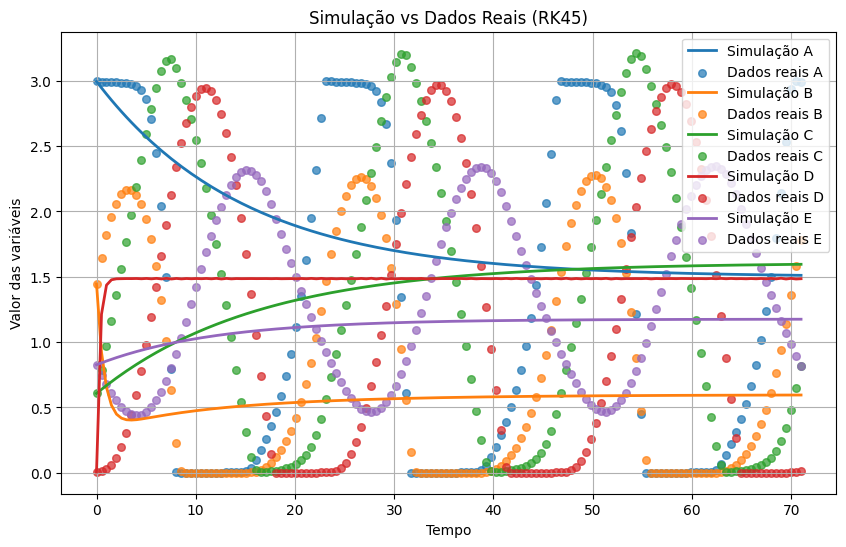

Sigma increased due to no improvement. New sigma: 2.8251861638984392, 'min': 27.936759657425007, 'max': 31.447490456578002}
Sigma increased due to no improvement. New sigma: 1.095386773960064, 'min': 27.08522760636768, 'max': 36.04072511091831}}6}}}}
Sigma increased due to no improvement. New sigma: 3.16725424533154784, 'min': 27.03865764375835, 'max': 29.048521804514525}}}
Sigma increased due to no improvement. New sigma: 4.98152201920895353, 'min': 27.7377580472541, 'max': 32.94068638569869}5}}


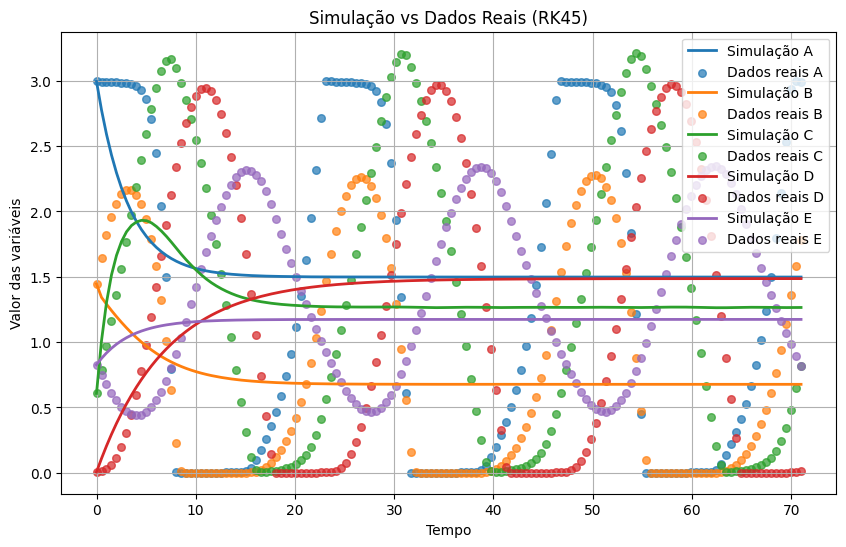

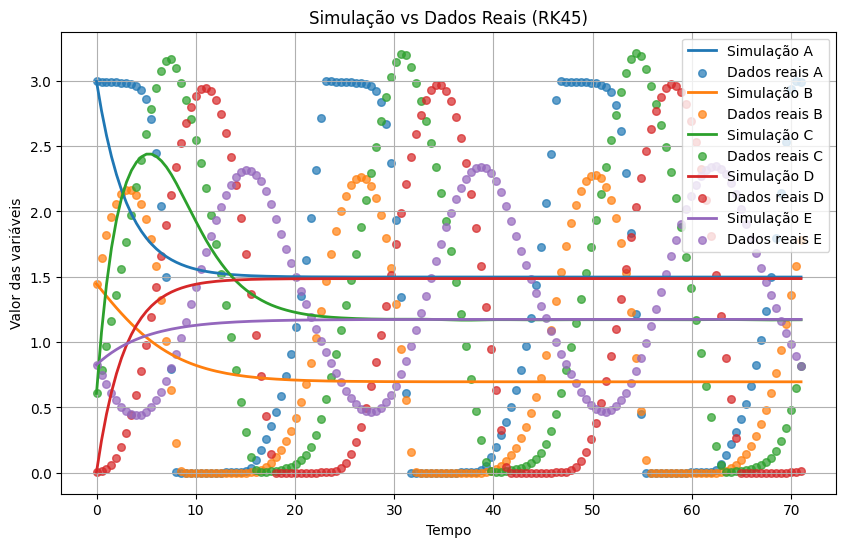

Sigma increased due to no improvement. New sigma: 1 2.5568676081161903, 'min': 26.63057864784249, 'max': 33.31498422540834}}}4}7}
Sigma increased due to no improvement. New sigma: 2.319962652599386406, 'min': 26.61255817058861, 'max': 34.71877819922241}4}}}
Sigma increased due to no improvement. New sigma: 11.625397303780822, 'min': 26.89908044453222, 'max': 33.576777349749634}5}}


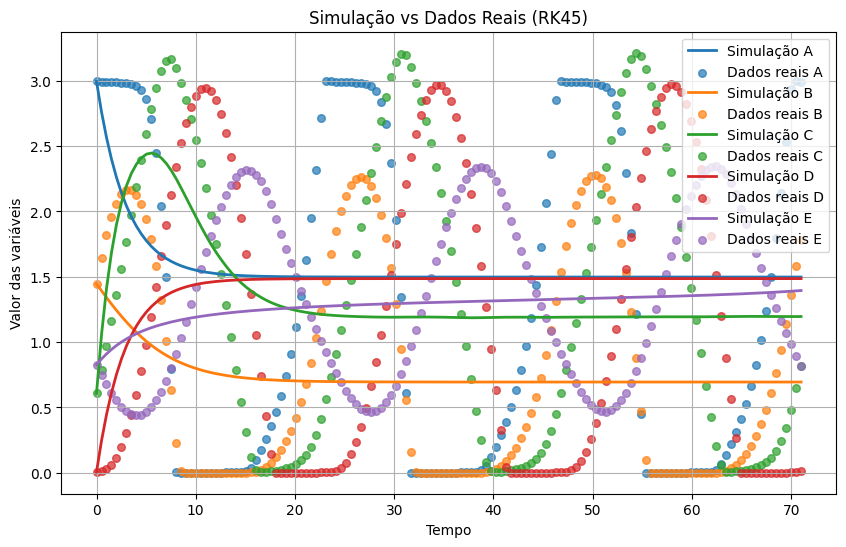

Sigma increased due to no improvement. New sigma: 9.5950337456633651719, 'min': 27.67849614120051, 'max': 28.12049549821906}}
Sigma increased due to no improvement. New sigma: 7.6315159675996464564, 'min': 27.2757834259327, 'max': 28.519890525747567}7}
Sigma increased due to no improvement. New sigma: 11.30635372089609797, 'min': 27.33125045180404, 'max': 27.639184676623962}2}
Sigma increased due to no improvement. New sigma: 9.17227551523492866, 'min': 26.99250095860598, 'max': 28.265163126596953}}8}
Sigma increased due to no improvement. New sigma: 8.4616977579085748054, 'min': 27.064551228409304, 'max': 27.953789370657816}
Sigma increased due to no improvement. New sigma: 13.60032742934204173, 'min': 27.15524953098737, 'max': 28.32445463091537}7}}
Sigma increased due to no improvement. New sigma: 13.56928636888479877, 'min': 27.034946782654803, 'max': 28.221101884248643}}


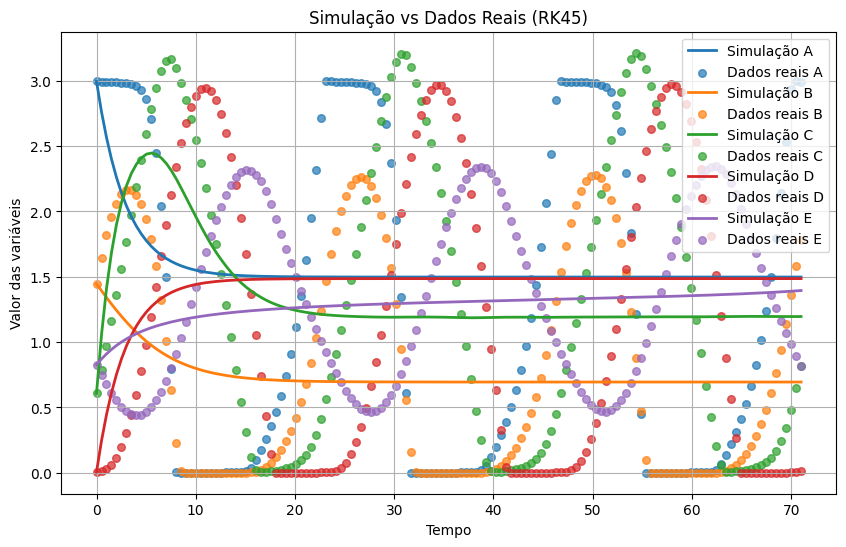

Sigma increased due to no improvement. New sigma: 13.69360554249885395, 'min': 27.039041051417733, 'max': 27.97154409842676}2}
Sigma increased due to no improvement. New sigma: 15.43821937233285546, 'min': 26.86417139874933, 'max': 28.269440145408147}}}
Sigma increased due to no improvement. New sigma: 150.0324535141566035, 'min': 26.772483628269516, 'max': 26.873952830240107}}}
Sigma increased due to no improvement. New sigma: 13.8339528778377988224, 'min': 26.745764105620403, 'max': 26.85353628039868}}
Sigma increased due to no improvement. New sigma: 12.551492269243674018, 'min': 26.75035702856574, 'max': 26.795521635584606}}}
Sigma increased due to no improvement. New sigma: 156638251295525798, 'min': 26.747501082040046, 'max': 29.27843118823066}77}}}
Sigma increased due to no improvement. New sigma: 10.8090273497698882464, 'min': 26.637017616633603, 'max': 26.733475976219072}


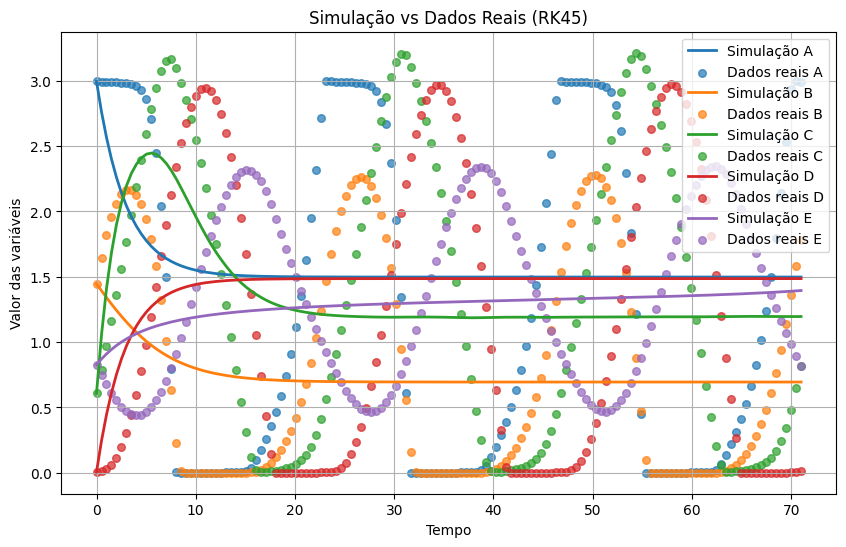

Sigma increased due to no improvement. New sigma: 150.11786501167821715, 'min': 26.631633296507374, 'max': 27.09427042829373}}}
Sigma increased due to no improvement. New sigma: 11.689938622957555067, 'min': 26.72993934199904, 'max': 26.74448459533251}}}
Sigma increased due to no improvement. New sigma: 150.026602819671462326, 'min': 26.624199767589506, 'max': 26.708245509501484}
Sigma increased due to no improvement. New sigma: 153252354469228507, 'min': 26.645351339334585, 'max': 31.59177861255084}}}44}
Sigma increased due to no improvement. New sigma: 15.32087614833176176, 'min': 26.616755580851112, 'max': 27.845876535235423}}


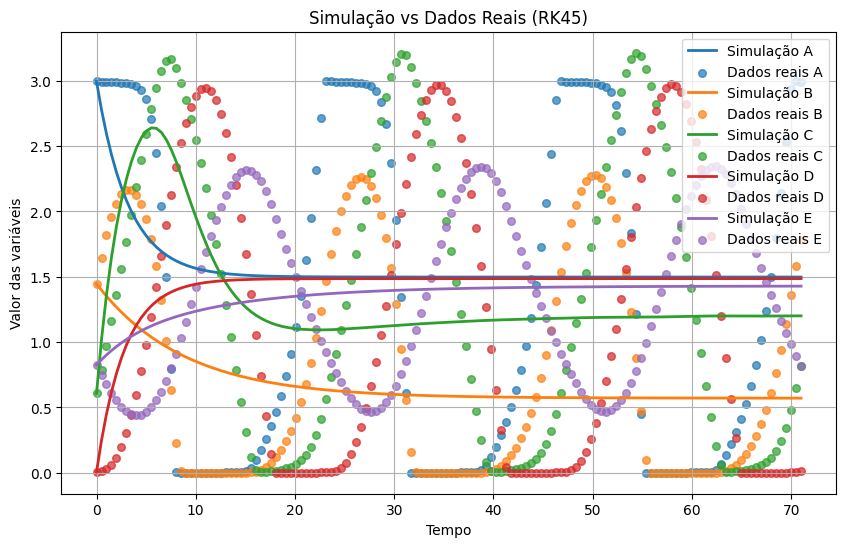

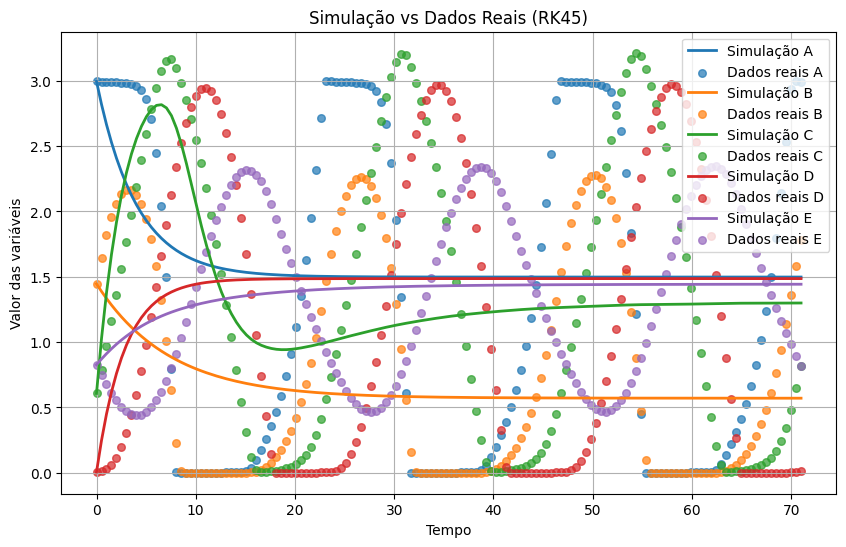

Sigma increased due to no improvement. New sigma: 1 9.219501153362108e-05, 'min': 26.44356017105499, 'max': 26.44384109967206}4}}


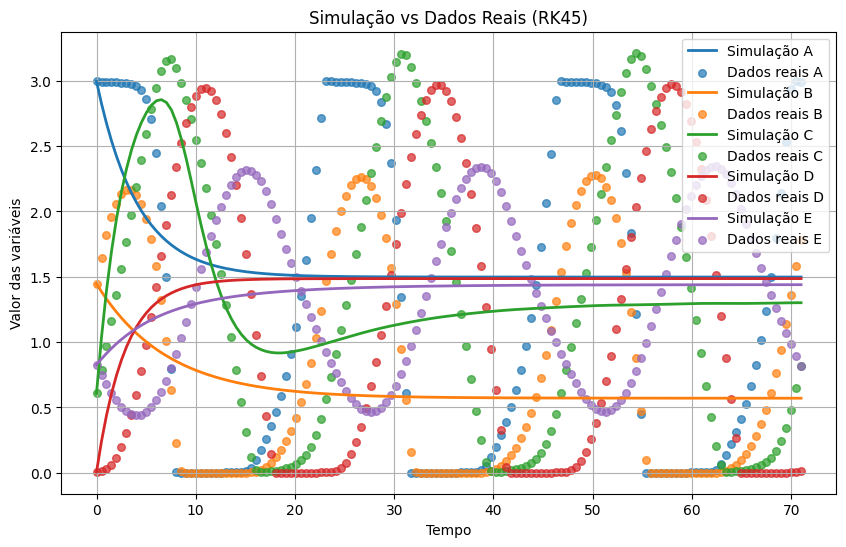

Sigma increased due to no improvement. New sigma: 1 0.0015405240846443934, 'min': 26.42906054006423, 'max': 26.43267883555405}}}
Sigma increased due to no improvement. New sigma: 1.768395130541271588726, 'min': 26.429087056030532, 'max': 26.432731200295684}
Sigma increased due to no improvement. New sigma: 1.031254370391367779974, 'min': 26.425765286843177, 'max': 26.429421487641246}


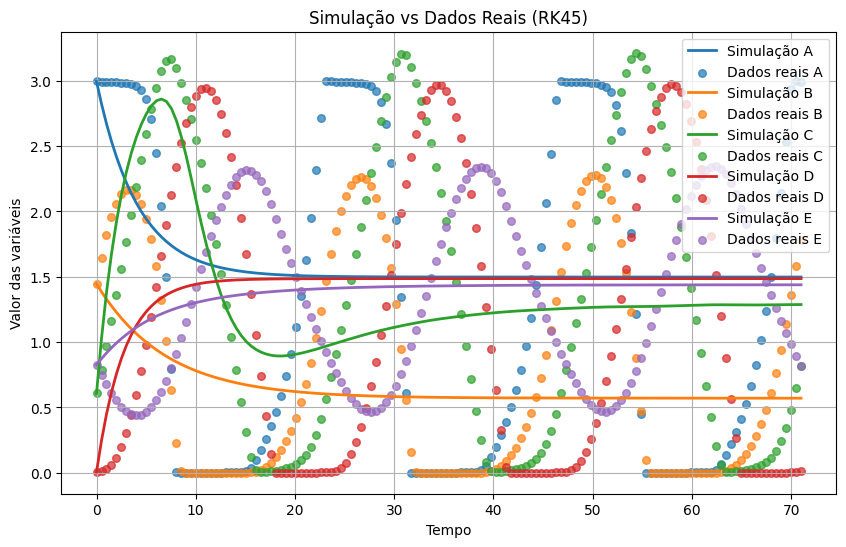

Sigma increased due to no improvement. New sigma: 1.62506006860943396766, 'min': 26.422632724436806, 'max': 26.426274846241082}}
Sigma increased due to no improvement. New sigma: 1.24821498038745034848, 'min': 26.41708449075465, 'max': 26.42073571819691}3}}


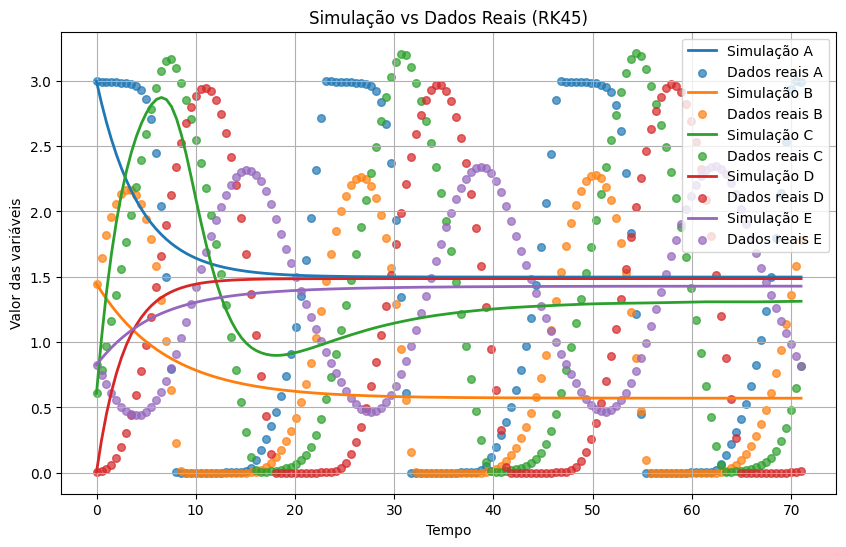

Sigma increased due to no improvement. New sigma: 3.787461764464208667257, 'min': 26.412956031725578, 'max': 26.416681030004685}
Sigma increased due to no improvement. New sigma: 1.594139016142728707478, 'min': 26.402968688017694, 'max': 26.406610024922188}
Sigma increased due to no improvement. New sigma: 3.3210772438271771354, 'min': 26.40297426035281, 'max': 26.40663861666113}002}


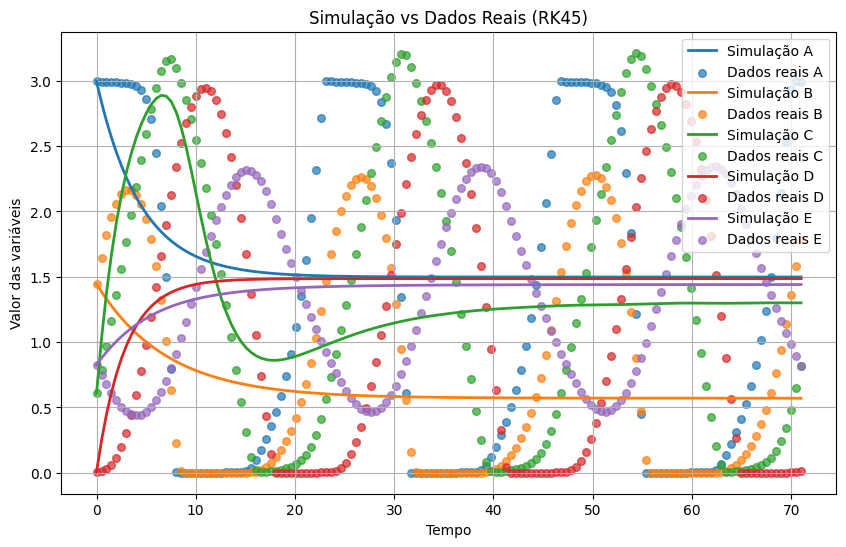

Sigma increased due to no improvement. New sigma: 152.3367872132052425, 'min': 26.40316613156235, 'max': 31.714598326930858}}5}
Sigma increased due to no improvement. New sigma: 15.0014636460634785528, 'min': 26.39975559515769, 'max': 26.40318988512089}8}}
Sigma increased due to no improvement. New sigma: 11.27375956139746774, 'min': 26.399534371317735, 'max': 33.474018125124786}}4}
Sigma increased due to no improvement. New sigma: 150.0016052437792181142, 'min': 26.399362322265993, 'max': 26.402915224450933}


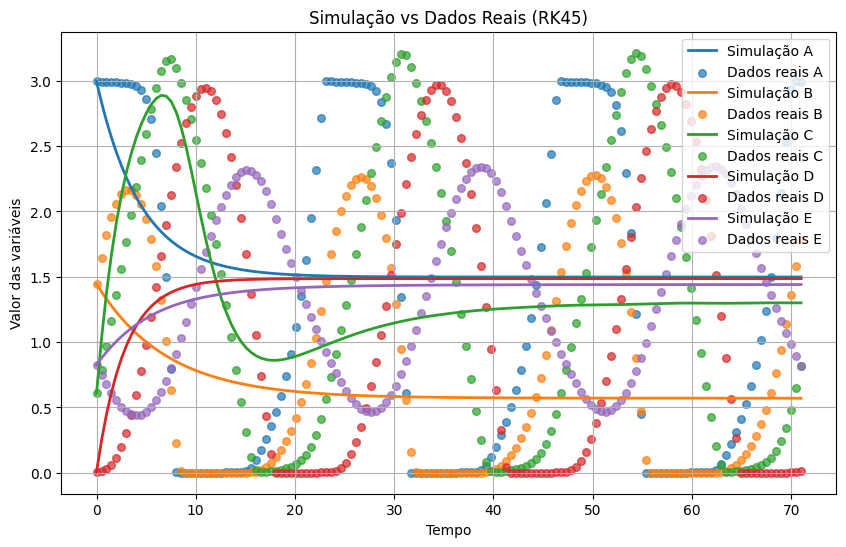

Sigma increased due to no improvement. New sigma: 151.8661113934105469, 'min': 26.39932656652425, 'max': 33.404180515286235}954}
Sigma increased due to no improvement. New sigma: 15.001424558315882281, 'min': 26.399235636058595, 'max': 26.402526685248123}5}
Sigma increased due to no improvement. New sigma: 13.756119617607927156, 'min': 26.399176920376803, 'max': 26.402350256393497}4}
Sigma increased due to no improvement. New sigma: 13.43547865582398941696, 'min': 26.39920613690308, 'max': 26.402375444897384}}
Sigma increased due to no improvement. New sigma: 12.679339153704420905, 'min': 26.399178213606785, 'max': 26.4021788617387}}}}}


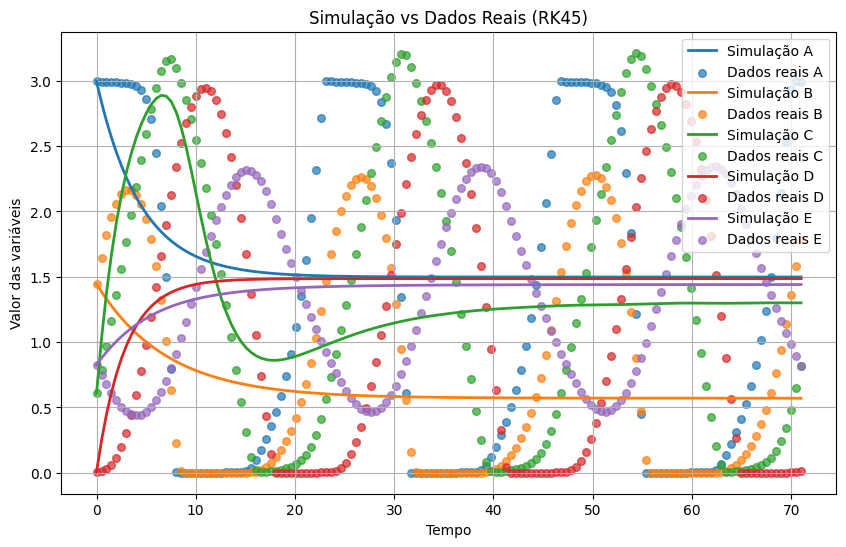

Sigma increased due to no improvement. New sigma: 150.0016368954887394282, 'min': 26.39950191010796, 'max': 26.403134598107588}}
Sigma increased due to no improvement. New sigma: 150.0013511218802320308, 'min': 26.399200462131322, 'max': 26.40231567305961}}
Sigma increased due to no improvement. New sigma: 15.001309964280927025, 'min': 26.399134318255495, 'max': 26.40216949090322}3}}
Sigma increased due to no improvement. New sigma: 15.0015128006490181154, 'min': 26.399104572097873, 'max': 26.40231498180738}}}


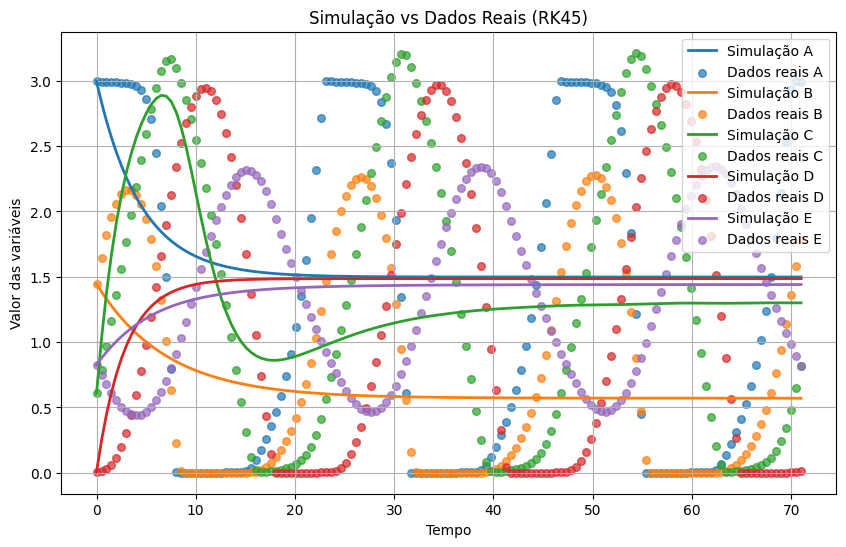

Sigma increased due to no improvement. New sigma: 150.0012906491063657212, 'min': 26.39909382983601, 'max': 26.402228748921377}}
Sigma increased due to no improvement. New sigma: 11.8731695426388153637, 'min': 26.399097042833006, 'max': 26.402218785263234}}
Sigma increased due to no improvement. New sigma: 14.79682443170953563176, 'min': 26.399087411376435, 'max': 26.402210241576856}
Sigma increased due to no improvement. New sigma: 150.0015048484325473697, 'min': 26.4003667660069, 'max': 26.403911806688438}}}


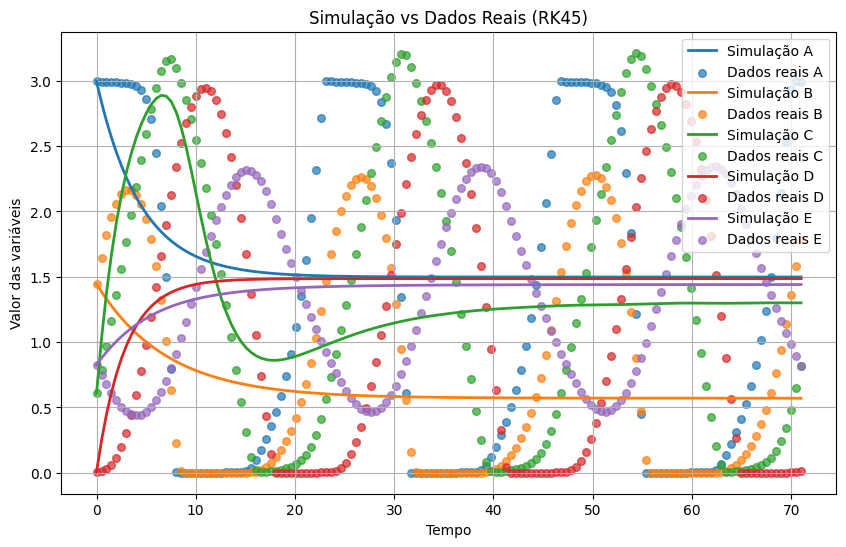

Sigma increased due to no improvement. New sigma: 150.0013269344173928754, 'min': 26.39998762740933, 'max': 26.40284812248434}}}
Sigma increased due to no improvement. New sigma: 5.8825582398603204579, 'min': 26.39997004674817, 'max': 26.402759669865425}18}
Sigma increased due to no improvement. New sigma: 7.924353429546192706, 'min': 26.399970541903315, 'max': 26.40275697203565}225}
Sigma increased due to no improvement. New sigma: 10.0882069988237221634, 'min': 26.39997006779569, 'max': 26.402759513016765}4}


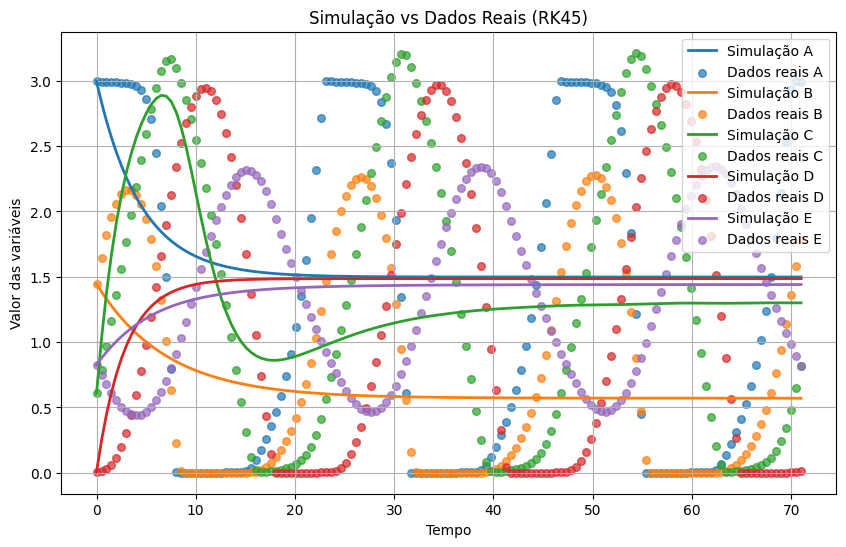

Sigma increased due to no improvement. New sigma: 11.09742738063543223594, 'min': 26.399970130601734, 'max': 26.40274782069254}}
Sigma increased due to no improvement. New sigma: 150.7676041191812155, 'min': 26.400039500663027, 'max': 28.530250230701313}93}
Sigma increased due to no improvement. New sigma: 150.21172249292656817, 'min': 26.399742292032357, 'max': 26.904938481139897}}}
Sigma increased due to no improvement. New sigma: 15.0013570889956073292, 'min': 26.399737513187844, 'max': 26.402474153535294}}


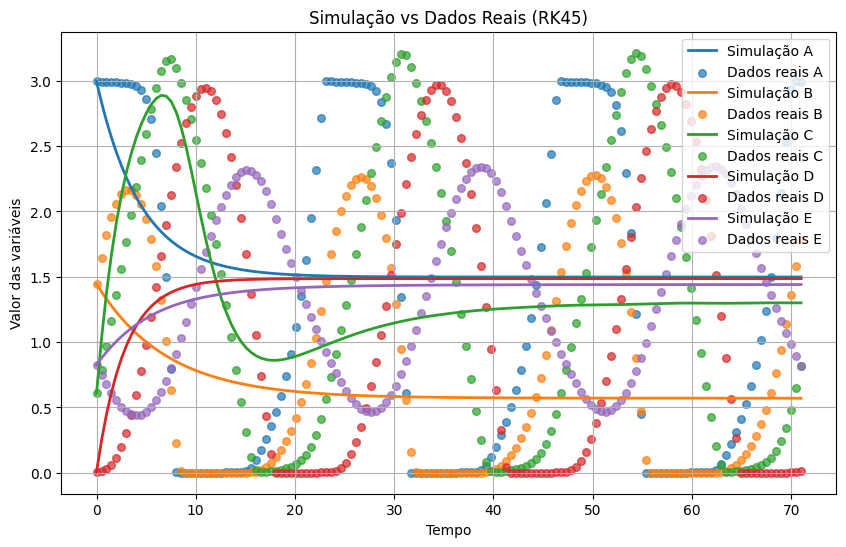

Sigma increased due to no improvement. New sigma: 3.300552169149378396346, 'min': 26.399737256242478, 'max': 26.402458038486582}
Sigma increased due to no improvement. New sigma: 1.16867503241103662192, 'min': 26.399737235943977, 'max': 26.40245804531082}}}
Sigma increased due to no improvement. New sigma: 1.157079786562048876507, 'min': 26.399737219607168, 'max': 26.40245784735543}}


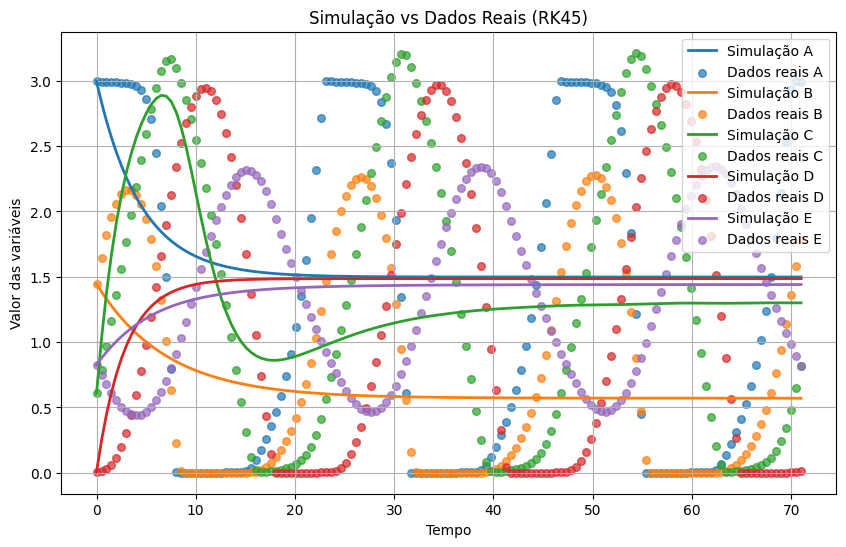

Sigma increased due to no improvement. New sigma: 1.625570785381728329346, 'min': 26.39973720783713, 'max': 26.402457588985015}}
Sigma increased due to no improvement. New sigma: 10.580524395400572, 'min': 26.399737204330165, 'max': 28.58035207835012}524}}}
Sigma increased due to no improvement. New sigma: 10.0011463281586268838, 'min': 26.399737203948376, 'max': 26.40245808472144}}}
Sigma increased due to no improvement. New sigma: 1.760943708603253608, 'min': 26.39973720103626, 'max': 28.58631184974961}}18}}


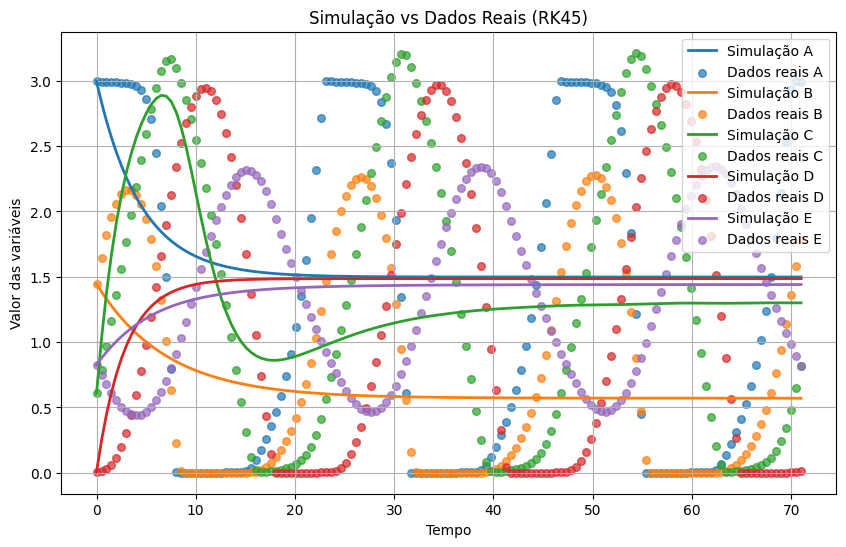

Sigma increased due to no improvement. New sigma: 3.19586752634203584, 'min': 26.399737197978563, 'max': 28.588878123077347}}7}}
Sigma increased due to no improvement. New sigma: 3.25935975129357675, 'min': 26.399737195491067, 'max': 28.5979724301073}3}}}}}
Sigma increased due to no improvement. New sigma: 4.127128254575825938, 'min': 26.399737191466283, 'max': 28.606526794873798}}}}


In [72]:
GENERATION_LIMIT = 10000
NO_IMPROVEMENT_LIMIT = 50
HARD_SIGMA_INCREASE_FACTOR = 10
TOLERANCE = 1E-4

# Inicialização da população
population = toolbox.generate()
Individual.apply_bounds(population)

# Loop de evolução
best_fitness = None
no_improvement_counter = 0
best_individual = None

for gen in range(GENERATION_LIMIT):
    
    # Avaliação da população
    for i, ind in enumerate(population):
        ind.fitness.values = toolbox.evaluate(ind)
        
    # Compilação de estatísticas
    record = stats.compile(population)
    
    # Atualização do melhor fitness
    current_best_fitness = min(ind.fitness.values[0] for ind in population)
    hof.update(population)
    
    # Controle de melhora no fitness
    if best_fitness is None or current_best_fitness < best_fitness - TOLERANCE:
        best_fitness = current_best_fitness
        no_improvement_counter = 0
        best_individual = hof[0]
    else:
        no_improvement_counter += 1
        
    # Aumenta sigma caso não haja melhora
    if no_improvement_counter >= (NO_IMPROVEMENT_LIMIT + gen/100):
        strategy.sigma = min(max(strategy.sigma*HARD_SIGMA_INCREASE_FACTOR, 1), 15)
        print(f"Sigma increased due to no improvement. New sigma: {strategy.sigma}")
        no_improvement_counter = 0
        
    # Atualização da estratégia e geração da próxima população
    toolbox.update(population)
    
    # Impressão das estatísticas da geração
    print(f"Generation {gen}: {record}", end='\r')
    
    # Visualiza o melhor indivíduo a cada 500 gerações
    if gen % 500 == 0:
        best_ind = Individual.list_to_ind(best_individual)
        best_ind.plot(comparison=False)
        
    # Gera nova população
    population = toolbox.generate()
    Individual.apply_bounds(population)